In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [2]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

In [3]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve()

We are in t = 69
We are in t = 68
We are in t = 67
We are in t = 66
We are in t = 65
We are in t = 64
We are in t = 63
We are in t = 62
We are in t = 61
We are in t = 60
We are in t = 59
We are in t = 58
We are in t = 57
We are in t = 56
We are in t = 55
We are in t = 54
We are in t = 53
We are in t = 52
We are in t = 51
We are in t = 50
We are in t = 49
We are in t = 48
We are in t = 47
We are in t = 46
We are in t = 45
We are in t = 44
We are in t = 43
We are in t = 42
We are in t = 41
We are in t = 40
We are in t = 39
We are in t = 38
We are in t = 37
We are in t = 36
We are in t = 35
We are in t = 34
We are in t = 33
We are in t = 32
We are in t = 31
We are in t = 30
We are in t = 29
We are in t = 28
We are in t = 27
We are in t = 26
We are in t = 25
We are in t = 24
We are in t = 23
We are in t = 22
We are in t = 21
We are in t = 20
We are in t = 19
We are in t = 18
We are in t = 17
We are in t = 16
We are in t = 15
We are in t = 14
We are in t = 13
We are in t = 12
We are in t = 

In [11]:
# %time model.simulate_prep()
%time model.simulate()

CPU times: total: 0 ns
Wall time: 0 ns


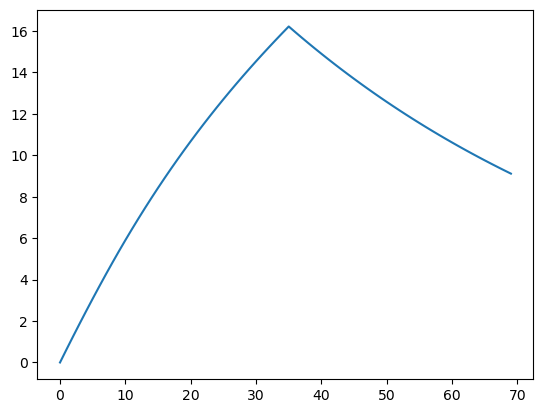

In [12]:
plt.plot(np.arange(par.T),np.mean(model.sim.k[:], axis=0))


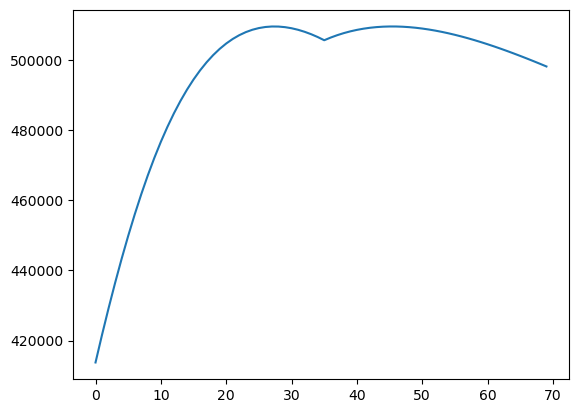

In [13]:
plt.plot(np.arange(par.T),np.mean(model.sim.w[:], axis=0))


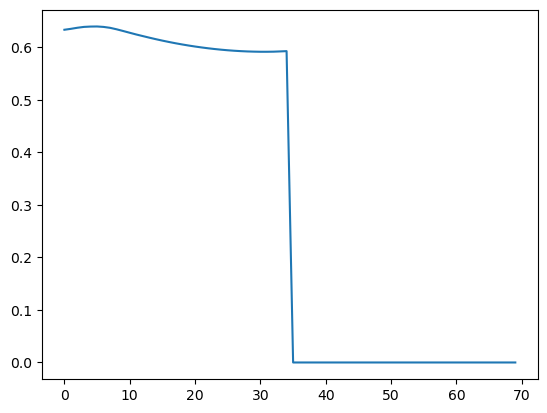

In [14]:
plt.plot(np.arange(par.T),np.mean(model.sim.h[:], axis=0))


In [15]:
model.sim.a

array([[ 135000.        ,  108202.81083363,   86179.11775346,
          69284.25533942,   57214.5618914 ,   49150.2851396 ,
          44658.92516994,   42878.97370427,   42932.05990073,
          43677.59082786,   44636.95358412,   45635.44916606,
          46548.36272399,   47457.40361018,   48288.81687364,
          49001.85664565,   49563.11105785,   50066.3654496 ,
          50437.52029499,   50721.95982032,   50933.24572359,
          51062.53117685,   51179.05121838,   51218.56740322,
          51285.36037011,   51287.26553416,   51330.16729162,
          51321.16550677,   51353.84096897,   51333.07505419,
          51353.49778578,   51325.16377734,   51324.42867374,
          51284.23805854,   51309.33034023,   51261.55629836,
          65784.90273311,  130137.96874401,  242411.779396  ,
         367701.09914749,  498908.49670839,  641669.75426504,
         792948.25865263,  952201.98288899, 1121628.54008142,
        1304815.06892121, 1153398.07941351, 1008147.11377856,
        

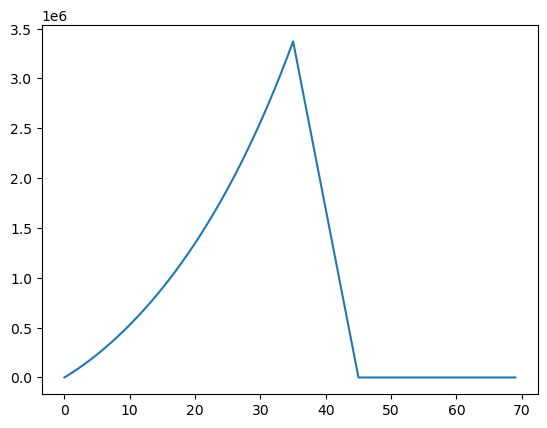

In [18]:
plt.plot(np.arange(par.T),np.mean(model.sim.s[:], axis=0))


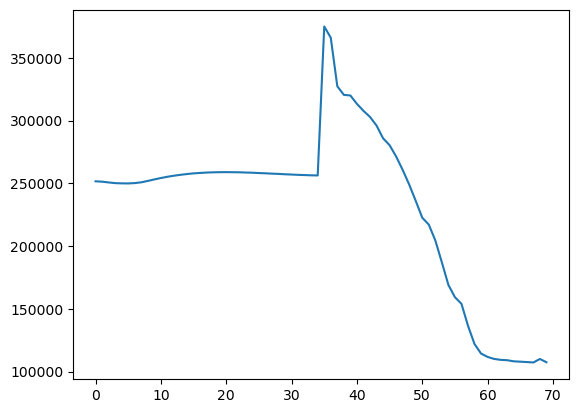

In [17]:
plt.plot(np.arange(par.T),np.mean(model.sim.c[:], axis=0))


In [12]:
(model.par.chi[-1]+model.par.a_bar)*(1/(1+(par.mu**(1/par.sigma))))

86414.03095581941

In [13]:
np.min(model.sol.a[:, :, :, :])

509.01510866800527

In [ ]:
plt.plot(sol.c[:, 0, 0, 0])

In [ ]:
plt.plot()

In [ ]:
plt.plot(np.arange(par.T),np.mean(model.sim.s[:], axis=0))


In [ ]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 1, 1, i])


In [ ]:
sol.V

In [ ]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.V[:, 1, 1, i])


In [ ]:
sol.V[:, 4, 4, :]

In [ ]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 4, 4, i])

In [ ]:
sol.V[:-1, 4, 4, 4]-sol.V[1:, 4, 4, 4]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 2
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 30
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()
